# Compare LaCE-NN vs LaCE-GP predictions, and a test simulation

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# our modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.gp_emulator import GPEmulator
from lace.utils import poly_p1d

### Load p1d archive (training and testing data)

In [3]:
# list of emulator parameters used with Gadget sims
emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']

In [4]:
archive = gadget_archive.GadgetArchive(postproc="Cabayol23")
training_data=archive.get_training_data(emu_params=emu_params)
len(training_data)

9900

### Setup emulators (NN and GP)

In [5]:
nn_emu = NNEmulator(archive=archive, emulator_label='Cabayol23')

Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user
Training samples in archive : 9900
Training NN on 9900 points
NN optimised in 109.97920417785645 seconds


In [6]:
gp_emu = GPEmulator(archive=archive, emulator_label='Cabayol23')

Use custom archive provided by the user
Select emulator in Cabayol23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


 /home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.48 seconds


### Testing data

In [7]:
def compare_vs_test_data(sim_label='mpg_central',residuals=True,plot_every_iz=2):
    testing_data = archive.get_testing_data(sim_label=sim_label)
    plt.figure(figsize=[18,8])
    Nz=len(testing_data)
    colors = plt.cm.jet(np.linspace(0,1,Nz))
    print('Nz',Nz)
    for iz in range(0,Nz,plot_every_iz):
        test_p1d = testing_data[iz]['p1d_Mpc']
        k_Mpc = testing_data[iz]['k_Mpc']

        # mask k range
        mask = (k_Mpc>0) & (k_Mpc<4)
        k_Mpc = k_Mpc[mask]
        test_p1d = test_p1d[mask]

        # smooth truth
        fit_p1d = poly_p1d.PolyP1D(k_Mpc, test_p1d, kmin_Mpc=1.e-5, kmax_Mpc=gp_emu.ndeg, deg=gp_emu.ndeg)
        test_p1d = fit_p1d.P_Mpc(k_Mpc)

        # ask emu predictions
        gp_p1d = gp_emu.emulate_p1d_Mpc(testing_data[iz],k_Mpc)
        nn_p1d = nn_emu.emulate_p1d_Mpc(testing_data[iz],k_Mpc)

        if residuals:
            plt.semilogx(k_Mpc,gp_p1d/test_p1d,color=colors[iz],ls='-')
            plt.semilogx(k_Mpc,nn_p1d/test_p1d,color=colors[iz],ls='--') 
        else:
            plt.loglog(k_Mpc,test_p1d,color=colors[iz],ls='-')
            plt.loglog(k_Mpc,gp_p1d,color=colors[iz],ls=':')
            plt.loglog(k_Mpc,nn_p1d,color=colors[iz],ls='-.')

    if residuals:
        plt.axvline(x=10,ls='-',color='black',label='gp / true')
        plt.axvline(x=10,ls='--',color='black',label='nn / true')
        plt.ylabel('P1D / true',fontsize=14)
    else:
        plt.axvline(x=10,ls='-',color='black',label='true')
        plt.axvline(x=10,ls=':',color='black',label='gp')
        plt.axvline(x=10,ls='-.',color='black',label='nn')
        plt.ylabel('P1D [Mpc]',fontsize=14)
    plt.legend(fontsize=14)
    plt.xlabel('k [1/Mpc]',fontsize=14)
    plt.xlim([np.min(k_Mpc),np.max(k_Mpc)])

Nz 11


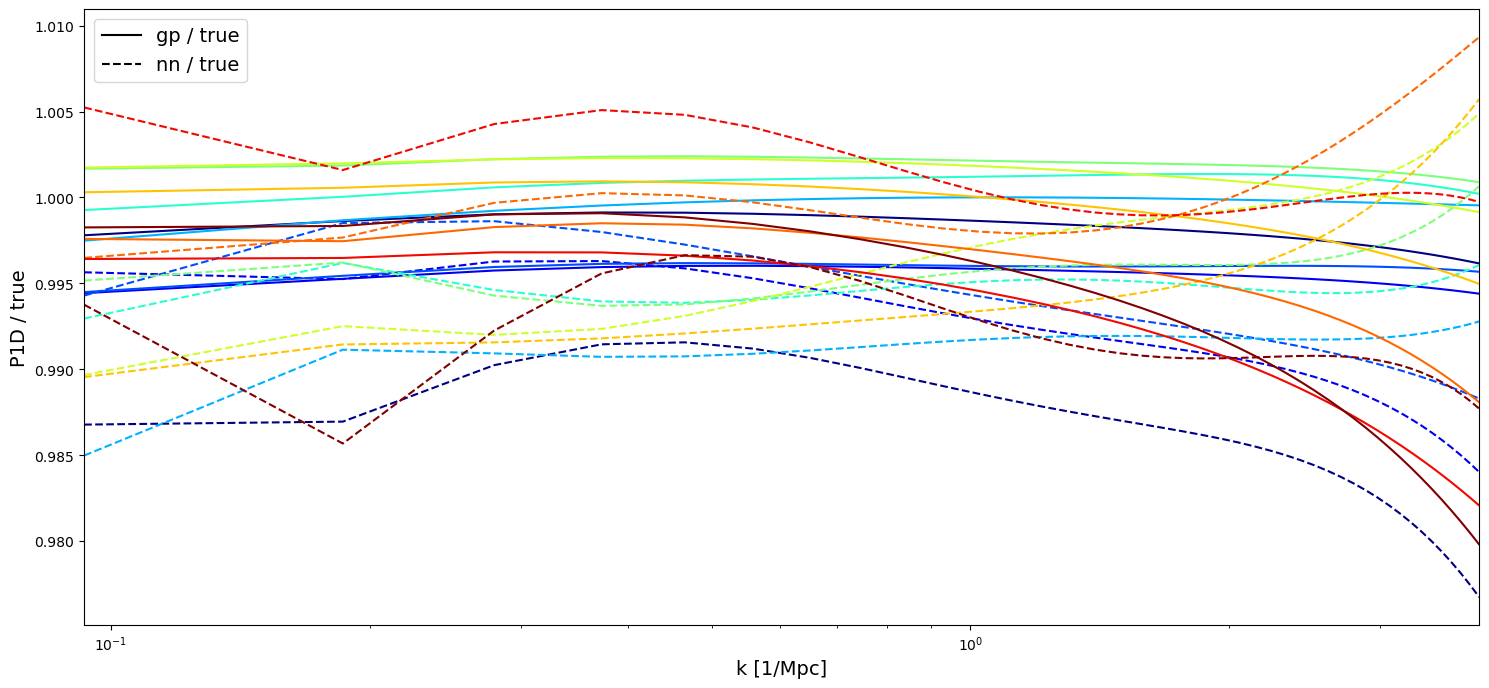

In [8]:
compare_vs_test_data(sim_label='mpg_neutrinos',residuals=True,plot_every_iz=1)

Nz 11


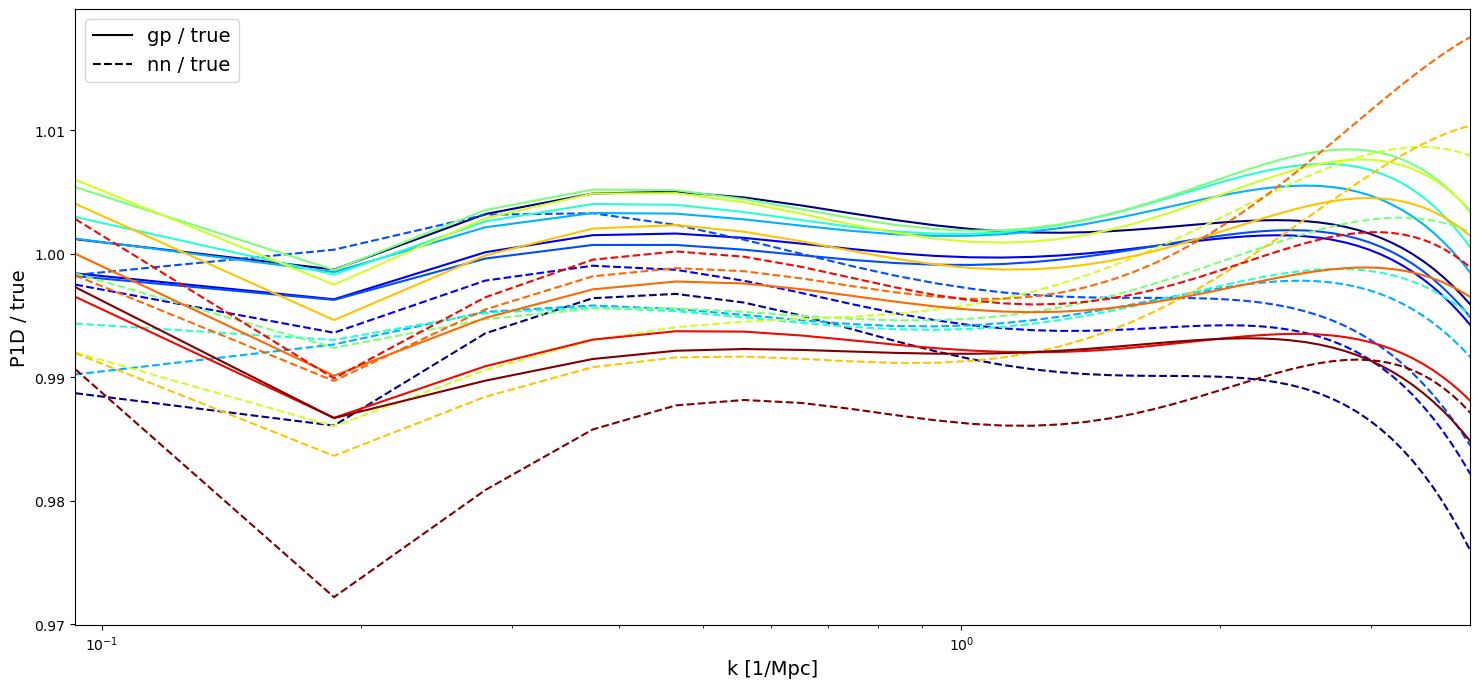

In [9]:
compare_vs_test_data(sim_label='mpg_seed',residuals=True,plot_every_iz=1)

Nz 11


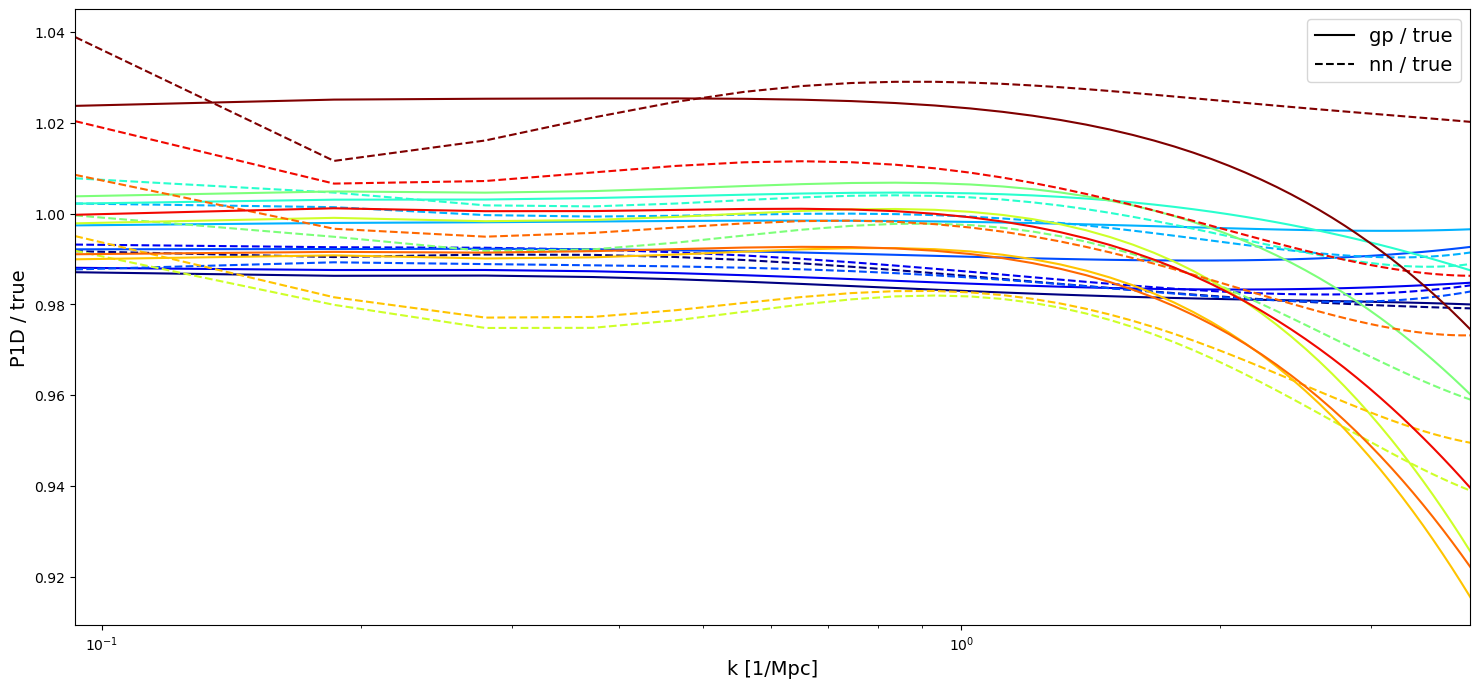

In [10]:
compare_vs_test_data(sim_label='mpg_reio',residuals=True,plot_every_iz=1)